In [1]:
from deeplearning_frameworks.autoencoder.plot import PlotOutlierAnalyzer

In [2]:
# -*- coding: utf-8 -*-
import os
import random
from typing import Tuple, List

import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, random_split

# -------------------------
# Configurações e semente
# -------------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# -------------------------
# Hiperparâmetros
# -------------------------
TICKER = "AAPL"
START_DATE = "2020-01-01"
END_DATE = "2025-12-01"

SEQ_LENGTH = 30          # janela de entrada
BATCH_SIZE = 64
HIDDEN_DIM = 64
LATENT_DIM = 16
NUM_LAYERS = 2
DROPOUT = 0.2

LEARNING_RATE = 1e-3      # base para OneCycleLR (max_lr será 10x por padrão)
EPOCHS = 100
PATIENCE = 12             # early stopping
TRAIN_VAL_SPLIT = 0.8     # 80% treino, 20% validação

OUTLIER_PERCENTILE = 95

# -------------------------
# Coleta e engenharia
# -------------------------
print("Coletando dados...")
df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False, auto_adjust=False)

if df.shape[0] < SEQ_LENGTH + 10:
    raise RuntimeError("Dados insuficientes para o comprimento de sequência escolhido.")

# Feature engineering:
# - log1p volume
# - returns (pct_change) do Close
# - high-low spread relativo
df["LogVolume"] = np.log1p(df["Volume"].fillna(0))
df["Return"] = df["Close"].pct_change().fillna(0)
df["HL_Spread"] = ((df["High"] - df["Low"]) / df["Close"]).fillna(0)

# Selecionar features utilizadas (pode ajustar)
feature_cols = ["Return", "HL_Spread", "LogVolume"]
data_features = df[feature_cols].values
dates = df.index.values
prices = df["Close"].values.reshape(-1, 1)

# -------------------------
# Normalização
# -------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(data_features)

# -------------------------
# Criação de sequências (entrada) e targets (próximo passo)
# input: seq_length timesteps -> target: features do timestep seq_length (o próximo)
# -------------------------
def create_sequences_targets(data: np.ndarray, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])  # next step
    return np.array(X), np.array(y)

X_all, y_all = create_sequences_targets(features_scaled, SEQ_LENGTH)
print(f"Total de sequências criadas: {X_all.shape[0]}  |  Shape X: {X_all.shape[1:]}  |  y shape: {y_all.shape}")

# -------------------------
# Dataset / Dataloaders (time-series split)
# -------------------------
class TimeSeriesForecastDataset(Dataset):
    """
    Dataset de sequences para previsão do próximo timestep.
    X: (n_samples, seq_length, n_features)
    y: (n_samples, n_features)
    """
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = TimeSeriesForecastDataset(X_all, y_all)

# time-based split: treino primeiros 80%, validação últimos 20%
n_total = len(dataset)
n_train = int(n_total * TRAIN_VAL_SPLIT)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(f"Treino: {len(train_dataset)} sequências | Val: {len(val_dataset)} sequências")

# -------------------------
# Modelo: Encoder LSTM + Attention (Multihead) + Decoder (proj -> output)
# -------------------------
class ForecastLSTMAE(nn.Module):
    """
    LSTM Encoder + Attention + Decoder para previsão do próximo timestep.
    Encoder produz sequência de hidden states; usamos atenção multi-head entre
    o vetor latente e os outputs do encoder para construir contexto para o decoder.
    """
    def __init__(self, seq_length: int, input_dim: int, hidden_dim: int, latent_dim: int,
                 num_layers: int = 2, dropout: float = 0.2, n_heads: int = 4):
        super().__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers

        # Encoder LSTM (retorna outputs para atenção e hidden final para projeção)
        self.encoder_lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0
        )

        # Projeto hidden_last -> latent
        self.encoder_fc = nn.Linear(hidden_dim, latent_dim)
        self.encoder_ln = nn.LayerNorm(latent_dim)
        self.dropout = nn.Dropout(dropout)

        # Projeção do latent para o espaço do attention query (hidden_dim)
        self.q_proj = nn.Linear(latent_dim, hidden_dim)

        # Multi-head attention: query from latent, key/value from encoder outputs
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=n_heads, batch_first=True)

        # Decoder head: a partir do contexto de atenção gerar features do próximo passo
        self.decoder_fc = nn.Linear(hidden_dim, hidden_dim)
        self.decoder_ln = nn.LayerNorm(hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_length, input_dim)
        Returns:
            y_pred: (batch, input_dim) -> previsão do próximo timestep
        """
        batch_size = x.size(0)
        encoder_outs, (h_n, c_n) = self.encoder_lstm(x)  # encoder_outs: (batch, seq_len, hidden_dim)

        hidden_last = h_n[-1]  # (batch, hidden_dim)
        latent = self.encoder_fc(hidden_last)  # (batch, latent_dim)
        latent = self.encoder_ln(latent)
        latent = self.dropout(latent)

        # montar query para atenção
        q = self.q_proj(latent).unsqueeze(1)  # (batch, 1, hidden_dim)
        # attn: query (1 token), key/value = encoder outputs (seq_len tokens)
        attn_out, attn_weights = self.attn(q, encoder_outs, encoder_outs)  # (batch, 1, hidden_dim)
        attn_out = attn_out.squeeze(1)  # (batch, hidden_dim)

        decoded = self.decoder_fc(attn_out)
        decoded = self.decoder_ln(decoded)
        decoded = self.dropout(decoded)

        y_pred = self.output_layer(decoded)  # (batch, input_dim)
        return y_pred

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        encoder_outs, (h_n, c_n) = self.encoder_lstm(x)
        hidden_last = h_n[-1]
        latent = self.encoder_fc(hidden_last)
        latent = self.encoder_ln(latent)
        return latent


input_dim = X_all.shape[2]
model = ForecastLSTMAE(
    seq_length=SEQ_LENGTH,
    input_dim=input_dim,
    hidden_dim=HIDDEN_DIM,
    latent_dim=LATENT_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    n_heads=4
).to(device)

print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parâmetros: {total_params:,} | Treináveis: {trainable:,}")

# -------------------------
# Otimizador, scheduler, loss
# -------------------------
criterion = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# OneCycleLR requires steps_per_epoch or total_steps
steps_per_epoch = max(1, len(train_loader))
total_steps = EPOCHS * steps_per_epoch
max_lr = LEARNING_RATE * 10

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    total_steps=total_steps,
    pct_start=0.1,
    anneal_strategy="linear"
)

# -------------------------
# Treinamento com validação e early stopping
# -------------------------
def train_loop(model, train_loader, val_loader, epochs, patience, device):
    best_val = float("inf")
    best_epoch = 0
    best_state = None
    train_losses = []
    val_losses = []
    patience_counter = 0

    print("Iniciando treinamento...")
    global_step = 0

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()
            global_step += 1

        avg_train = epoch_loss / len(train_loader)
        train_losses.append(avg_train)

        # Validação
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                y_pred = model(X_val)
                loss_val = criterion(y_pred, y_val)
                val_loss += loss_val.item()
        avg_val = val_loss / len(val_loader)
        val_losses.append(avg_val)

        print(f"Epoch {epoch:03d} | Train Loss: {avg_train:.6f} | Val Loss: {avg_val:.6f} | LR: {optimizer.param_groups[0]['lr']:.6e}")

        # early stopping
        if avg_val < best_val - 1e-8:
            best_val = avg_val
            best_epoch = epoch
            best_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping atingido em epoch {epoch}. Melhor Val Loss: {best_val:.6f} (epoch {best_epoch})")
            break

    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"Modelo restaurado para melhor época {best_epoch} com Val Loss {best_val:.6f}")

    return train_losses, val_losses, best_epoch

train_losses, val_losses, best_epoch = train_loop(model, train_loader, val_loader, EPOCHS, PATIENCE, device)

# -------------------------
# Avaliação / detecção de outliers
# - calculamos erro entre y_true e y_pred para todo conjunto (treino+val)
# - threshold via distribuição lognormal dos erros
# -------------------------
model.eval()
all_X = torch.FloatTensor(X_all).to(device)
with torch.no_grad():
    preds = []
    batch_size_eval = 1024
    for i in range(0, len(all_X), batch_size_eval):
        xb = all_X[i:i+batch_size_eval]
        preds.append(model(xb).cpu().numpy())
    preds = np.vstack(preds)

y_true = y_all  # já em numpy
errors = np.mean((y_true - preds) ** 2, axis=1)  # MSE por amostra (próximo passo)

# threshold lognormal
log_errors = np.log1p(errors)  # log(1 + erro) para estabilidade
mu = np.mean(log_errors)
sigma = np.std(log_errors)
threshold = np.expm1(mu + 3 * sigma)  # limiar = exp(mu + 3*sigma) - 1
outliers_mask = errors > threshold

n_outliers = outliers_mask.sum()
pct_outliers = n_outliers / len(outliers_mask) * 100.0

print(f"Threshold (lognormal, 3 sigma): {threshold:.6e}")
print(f"Outliers detectados: {n_outliers} / {len(outliers_mask)} ({pct_outliers:.2f}%)")

# -------------------------
# Relacionar outliers com datas e preços (próximo passo corresponde ao índice seq_length..end)
# -------------------------
error_dates = dates[SEQ_LENGTH:SEQ_LENGTH + len(errors)]
prices_next = prices[SEQ_LENGTH:SEQ_LENGTH + len(errors), 0]

outlier_indices = np.where(outliers_mask)[0]
outlier_info = []
for idx in outlier_indices[:20]:
    outlier_info.append({
        "index": int(idx),
        "date": pd.to_datetime(error_dates[idx]).strftime("%Y-%m-%d"),
        "close_next": float(prices_next[idx]),
        "mse": float(errors[idx])
    })
outlier_df = pd.DataFrame(outlier_info)
print("\nPrimeiros outliers detectados (até 20):")
print(outlier_df.to_string(index=False))

# -------------------------
# Estatísticas do erro
# -------------------------
print("\nEstatísticas dos erros (MSE por amostra):")
print(f"Média: {errors.mean():.6e}")
print(f"Mediana: {np.median(errors):.6e}")
print(f"Máximo: {errors.max():.6e}")
print(f"Mínimo: {errors.min():.6e}")
print(f"Desvio padrão: {errors.std():.6e}")

# -------------------------
# (Opcional) salvar modelo e scalers
# -------------------------
save_dir = "model_artifacts"
os.makedirs(save_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(save_dir, "forecast_lstm_ae.pth"))
import joblib
joblib.dump(scaler, os.path.join(save_dir, "scaler.gz"))

print(f"\nModelo e scaler salvos em {save_dir}")
print("Concluído.")


Usando dispositivo: cpu
Coletando dados...
Total de sequências criadas: 1456  |  Shape X: (30, 3)  |  y shape: (1456, 3)
Treino: 1164 sequências | Val: 292 sequências
ForecastLSTMAE(
  (encoder_lstm): LSTM(3, 64, num_layers=2, batch_first=True, dropout=0.2)
  (encoder_fc): Linear(in_features=64, out_features=16, bias=True)
  (encoder_ln): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (q_proj): Linear(in_features=16, out_features=64, bias=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (decoder_fc): Linear(in_features=64, out_features=64, bias=True)
  (decoder_ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (output_layer): Linear(in_features=64, out_features=3, bias=True)
)
Parâmetros: 74,227 | Treináveis: 74,227
Iniciando treinamento...
Epoch 001 | Train Loss: 0.182200 | Val Loss: 0.035557 | LR: 1.365363e-03
Epoch 002 | Train Loss: 0.0678

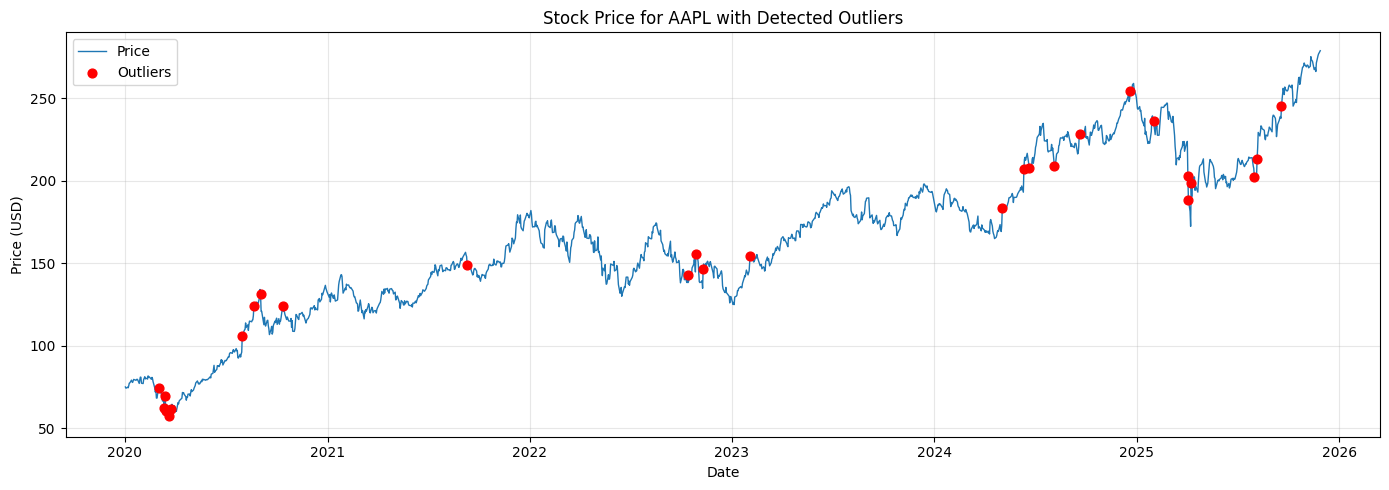

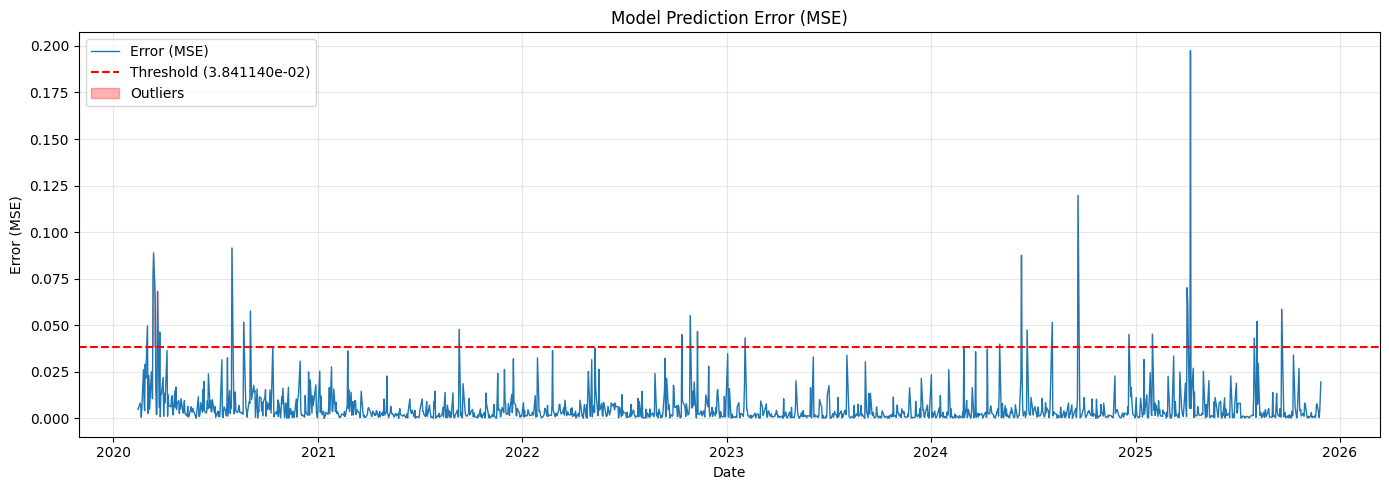

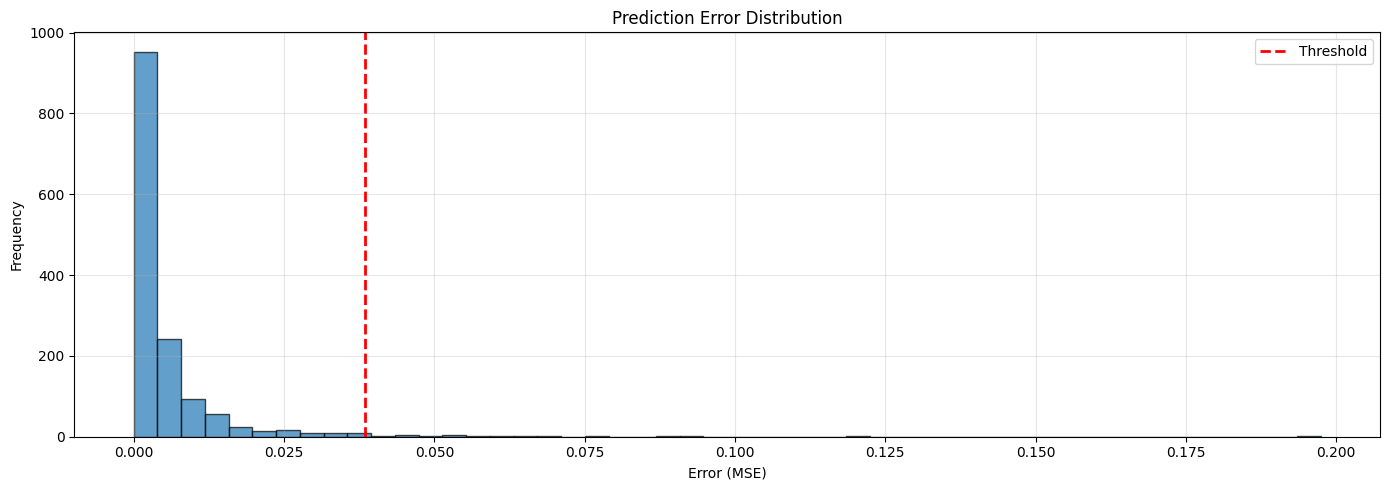

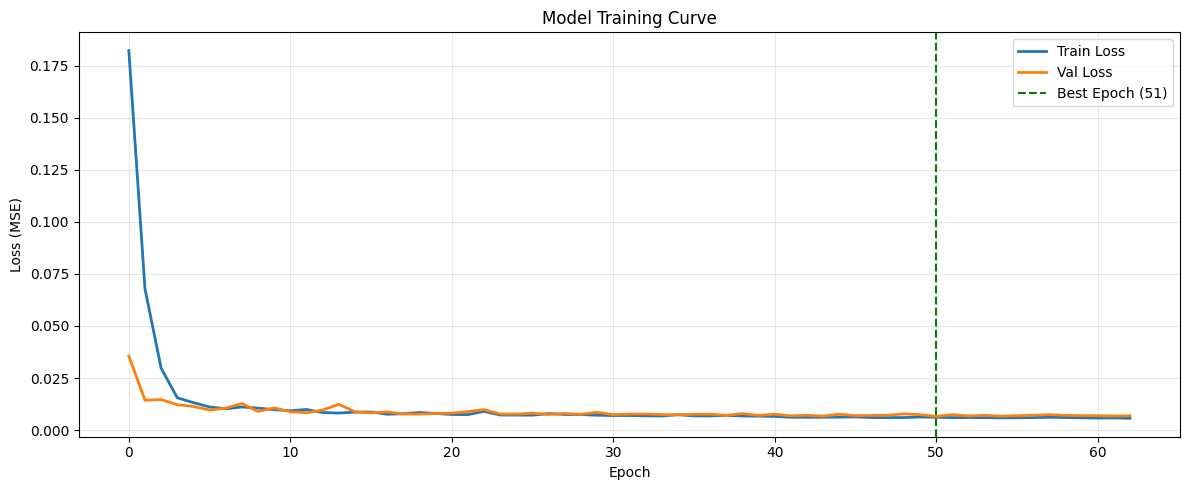

In [3]:
analyzer = PlotOutlierAnalyzer(
    dates=dates,
    prices=prices,
    errors=errors,
    outliers_mask=outliers_mask,
    threshold=threshold,
    train_losses=train_losses,
    val_losses=val_losses,
    best_epoch=best_epoch,
    seq_length=SEQ_LENGTH
)

analyzer.plot_all(ticker=TICKER)
